In [3]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd

# Load the dataset
df = pd.read_csv('Phishing Websites Engineered.csv')

# Features and target
X = df.drop(columns='target')
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Replace -1 with 0 in the target variable
y_train = y_train.replace(-1, 0)
y_test = y_test.replace(-1, 0) # Also replace in y_test for consistency

# Now you can fit the model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [5]:
y_pred3 = xgb_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred3))
print(classification_report(y_test, y_pred3))

Accuracy: 0.9572649572649573
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       620
           1       0.95      0.96      0.95       550

    accuracy                           0.96      1170
   macro avg       0.96      0.96      0.96      1170
weighted avg       0.96      0.96      0.96      1170



🔍 SHAP Summary Plot - XGboost


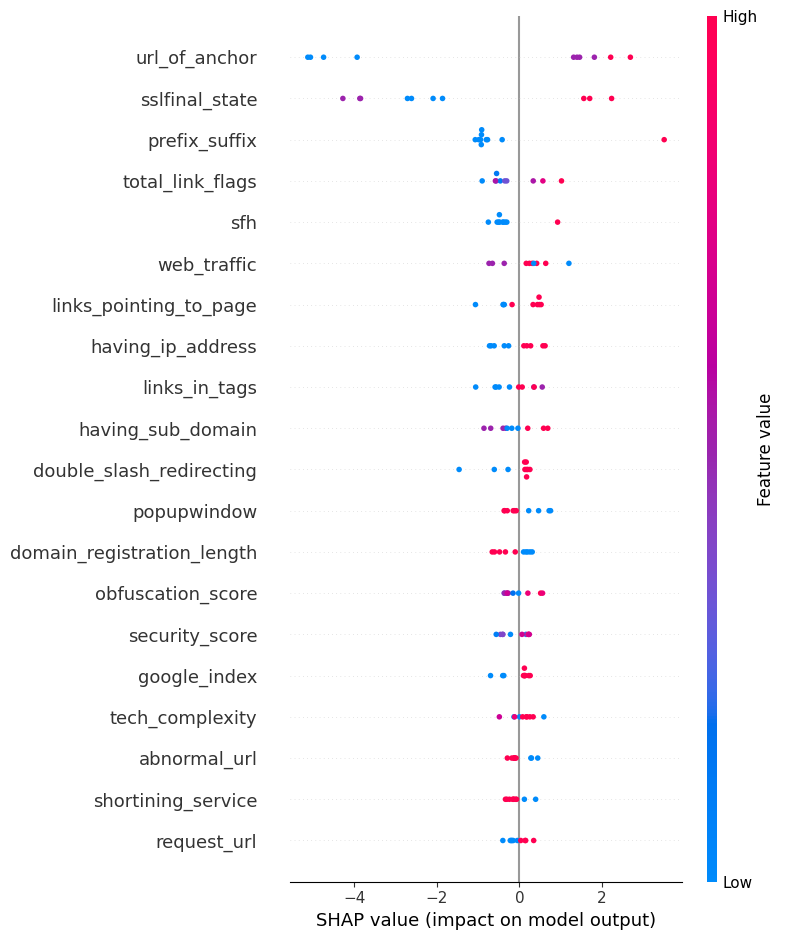

In [6]:
import shap
import matplotlib.pyplot as plt
background = shap.sample(X_train, 100, random_state=42)

# Create SHAP TreeExplainer for Random Forest
xgb_explainer = shap.TreeExplainer(xgb_model, background)

# Pick a few test instances
sample = X_test.sample(10, random_state=42)

# Compute SHAP values
xgb_shap_values = xgb_explainer.shap_values(sample)

# For binary classification, select SHAP values for the positive class (index 1)
# For multiclass, you may need to loop through each class or select one
if len(xgb_shap_values.shape) == 3:
    xgb_shap_values = xgb_shap_values[:, :, 1]
elif isinstance(xgb_shap_values, list):
    xgb_shap_values = xgb_shap_values[1]

# Visualize SHAP summary plot
print("🔍 SHAP Summary Plot - XGboost")
shap.summary_plot(xgb_shap_values, sample, show=False)
plt.tight_layout()
plt.show()

In [7]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7bf7e31f013c9e212aba558c945aff36a2c22d96b82537a62428f9bd1538df04
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [8]:
import lime
import lime.lime_tabular
import numpy as np


In [9]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X.columns.tolist(),
    class_names=['Legitimate', 'Phishing'],
    mode='classification'
)

In [10]:
def explain_instance_lime(model, model_name):
    i = np.random.randint(0, X_test.shape[0])
    exp = lime_explainer.explain_instance(
        X_test.iloc[i],
        model.predict_proba,
        num_features=10
    )
    print(f"\n🔍 LIME Explanation for model: {model_name} on instance {i}")
    exp.show_in_notebook(show_table=True)
    return exp

In [11]:
# Explain one instance with each model
explain_instance_lime(xgb_model, "XGboost")

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.


🔍 LIME Explanation for model: XGboost on instance 548




# PFI


Top 5 Features by Permutation Feature Importance (PFI):
                   Feature  Importance
13           url_of_anchor    0.105812
7           sslfinal_state    0.099487
5            prefix_suffix    0.021282
28  links_pointing_to_page    0.013077
25             web_traffic    0.012051


<Figure size 1000x600 with 0 Axes>

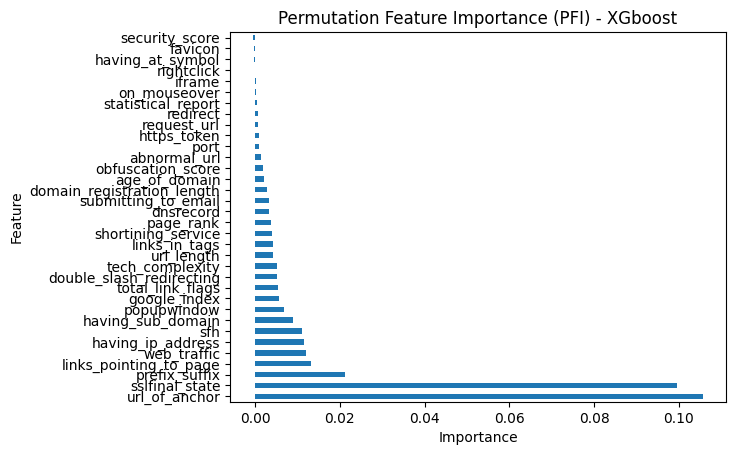

In [28]:
from sklearn.inspection import permutation_importance
pfi_result = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)

pfi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': pfi_result.importances_mean
}).sort_values(by='Importance', ascending=False)

print("\nTop 5 Features by Permutation Feature Importance (PFI):")
print(pfi_df.head())

plt.figure(figsize=(10, 6))
pfi_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title("Permutation Feature Importance (PFI) - XGboost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# LOFO

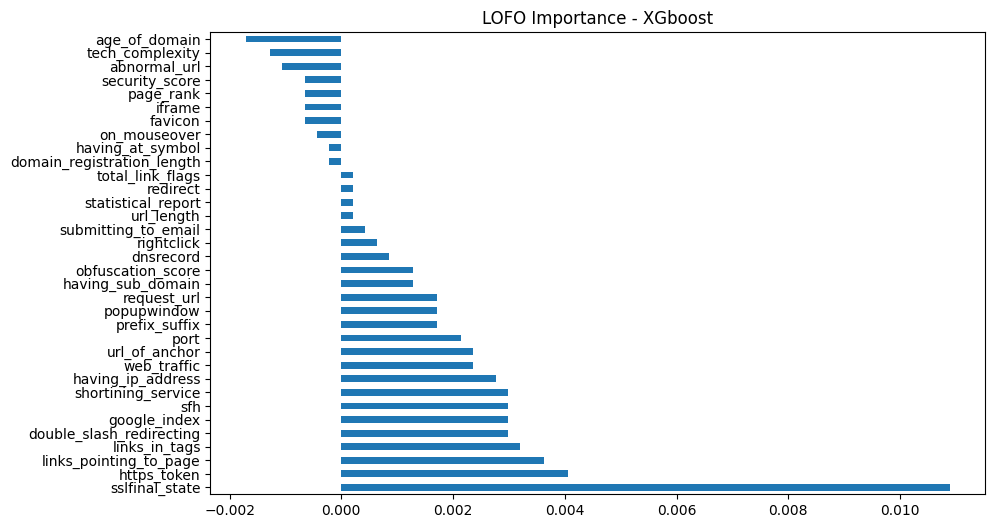

In [16]:
from sklearn.model_selection import cross_val_score
baseline = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy').mean()

lofo_scores = {}
for col in X_train.columns:
    X_lofo = X_train.drop(columns=[col])
    score = cross_val_score(xgb_model, X_lofo, y_train, cv=5, scoring='accuracy').mean()
    lofo_scores[col] = baseline - score

# Create DataFrame for LOFO scores and plot
lofo_df = pd.Series(lofo_scores).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
lofo_df.plot(kind='barh')
plt.title("LOFO Importance - XGboost")
plt.show()

In [17]:
print("\nTop 5 Features by LOFO Importance:")
print(lofo_df.head())


Top 5 Features by LOFO Importance:
sslfinal_state              0.010899
https_token                 0.004061
links_pointing_to_page      0.003631
links_in_tags               0.003203
double_slash_redirecting    0.002992
dtype: float64
